## Cardiovascular Disease Bayesian Network

### Cardiovascular disease topic
Intro to cardiovascular deasease

### What's a Bayesian Network?
Sprazi di teoria

### Why a Bayesian Network?
Spiegare perché si è scelta

### Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from pgmpy.estimators import PC, HillClimbSearch, TreeSearch, ExhaustiveSearch, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination


### Utils

In [3]:
def dataset_split(df, test_size=0.1):
    df = df.drop('id', axis=1)
    train_set, test_set = train_test_split(df, test_size=test_size)

    # save to csv
    test_set.to_csv('cardio_test_set.csv', index=False, sep=";")
    train_set.to_csv('cardio_train_set.csv', index=False, sep=";")

def draw_graphs(models, nrows=1, ncols=1, figsize=(15, 8)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, model in enumerate(models):
        graph = nx.DiGraph()
        graph.add_edges_from(model.edges())
        nx.draw_networkx(graph, pos=nx.circular_layout(graph), with_labels=True, ax= axes if not isinstance(axes, np.ndarray) else axes[i])

    plt.show()

def print_bin_cat_distribution(df, cat_cols=["cholesterol", "gluc"], nrows=2, ncols=4, figsize=(25, 10)):
    binary_cols = ["gender", "smoke", "alco", "active", "cardio_disease"]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(binary_cols + cat_cols):
        if col == "gender":
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_xticklabels(["women", "men"])
        elif col == "cholesterol" or col == "gluc":
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_xticklabels(["normal", "above normal", "well above normal"])
        else:
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_xlabel(col)

def print_numeric_distribution(df, numeric_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_xlabel(col)

def interval_discr(dataset, bins):
    min_value = dataset.min()
    max_value = dataset.max()
    interval_size = (max_value - min_value) / bins
    interval_edges = [min_value + i * interval_size for i in range(bins+1)]

    # Genera le etichette personalizzate per gli intervalli
    labels = [i for i in range(bins)]

    return (pd.cut(dataset, bins=interval_edges, include_lowest=True),
            pd.cut(dataset, bins=interval_edges, labels=labels, include_lowest=True))

    

### Dataset
Piccola intro sul dataset

In [4]:
df = pd.read_csv('cardio_dataset.csv', sep=';')

#### Dataset Analysis

##### Description

In [4]:
# Shows first dataframe rows
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# 'age' column to years
df['age'] = (df['age'] / 365).astype(int)

# to int
df['weight'] = df['weight'].astype(int)

# renaming cardio in cardio_disease
df = df.rename(columns={'cardio': 'cardio_disease'})

In [6]:
df.describe().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
count,70000.00,70000.00,70000.00,70000.00,70000.0,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.0,70000.0
mean,49972.42,52.84,1.35,164.36,74.2,128.82,96.63,1.37,1.23,0.09,0.05,0.8,0.5
std,28851.30,6.77,0.48,8.21,14.4,154.01,188.47,0.68,0.57,0.28,0.23,0.4,0.5
min,0.00,29.00,1.00,55.00,10.0,-150.00,-70.00,1.00,1.00,0.00,0.00,0.0,0.0
25%,25006.75,48.00,1.00,159.00,65.0,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
50%,50001.50,53.00,1.00,165.00,72.0,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
75%,74889.25,58.00,2.00,170.00,82.0,140.00,90.00,2.00,1.00,0.00,0.00,1.0,1.0
max,99999.00,64.00,2.00,250.00,200.0,16020.00,11000.00,3.00,3.00,1.00,1.00,1.0,1.0


In [7]:
# Check null values
df.isnull().sum()

id                0
age               0
gender            0
height            0
weight            0
ap_hi             0
ap_lo             0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio_disease    0
dtype: int64

##### Distribution Analysis

Numeric variable distribution

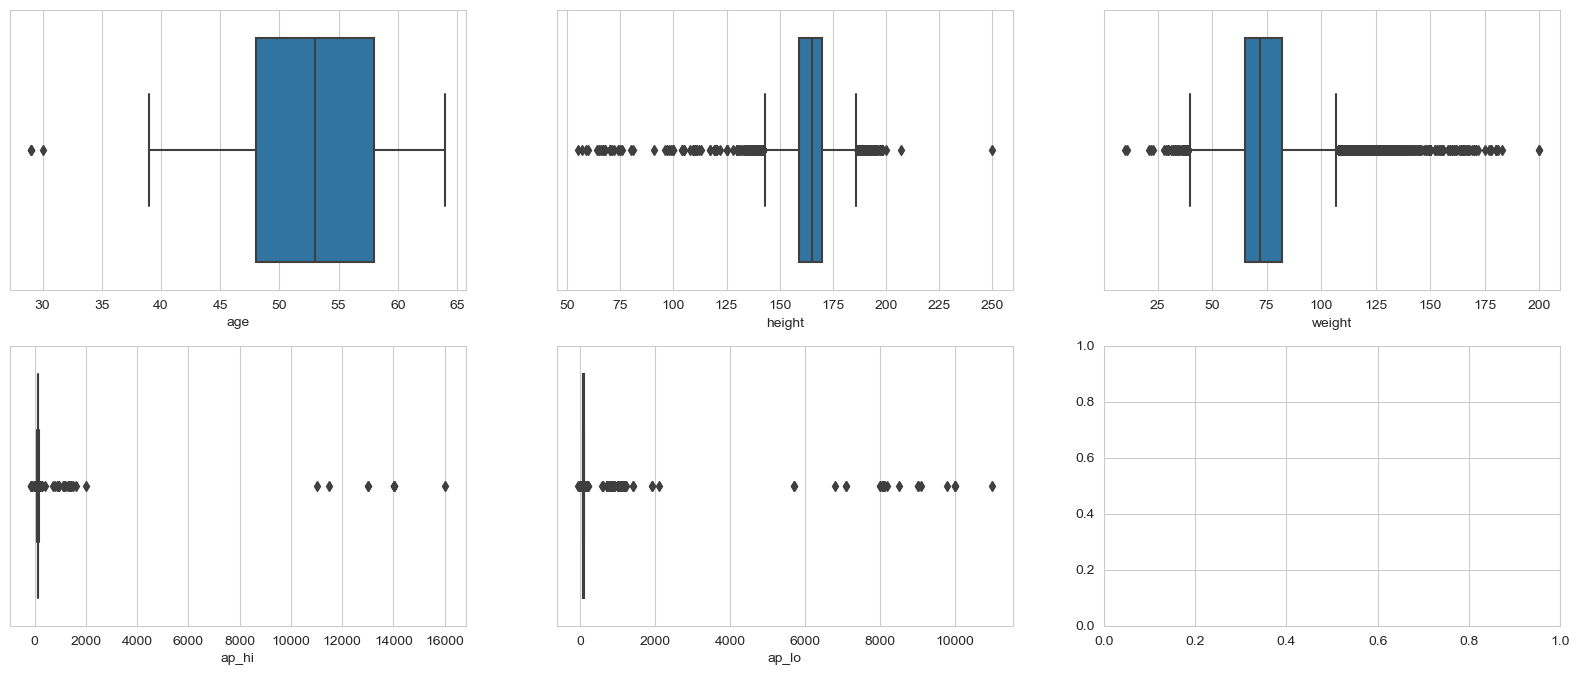

In [21]:
print_numeric_distribution(df)

As we can see above, there are several outliers that may influence the bayesian network, we are going to study it in the sections below

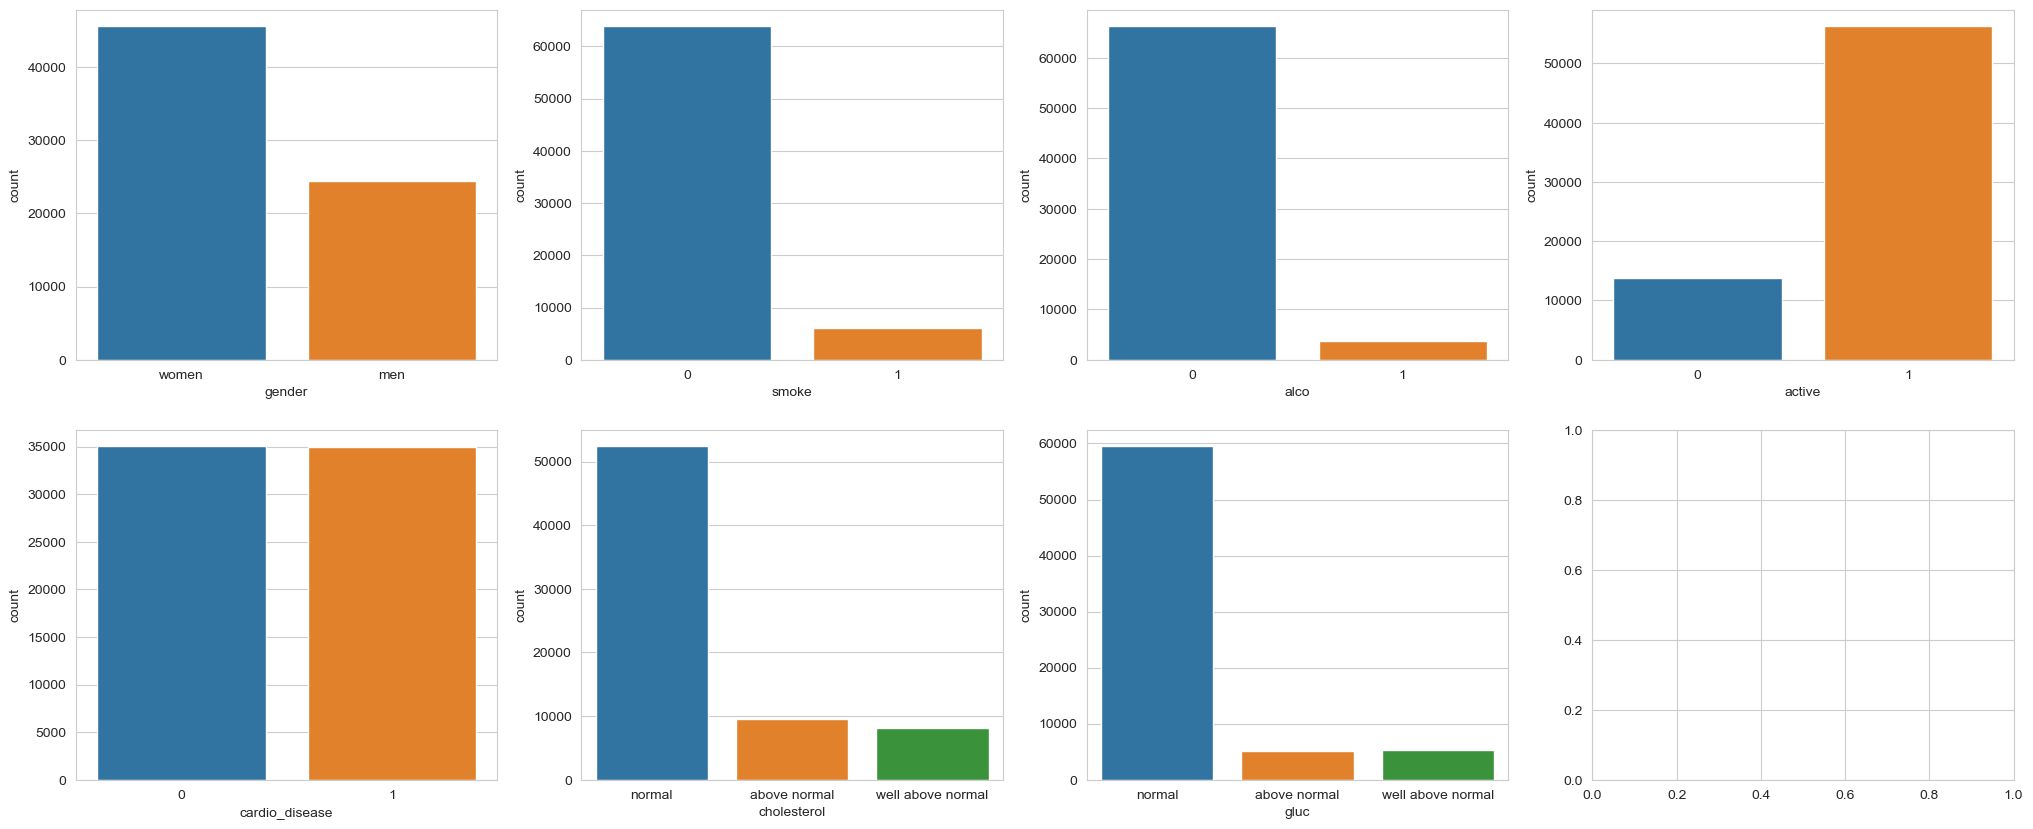

In [14]:
print_bin_cat_distribution(df)

##### Correlation Matrix

Check the correlation among variables through a Pearson correlation matrix heatmap.

Text(0.5, 1.0, 'Correlation Heatmap')

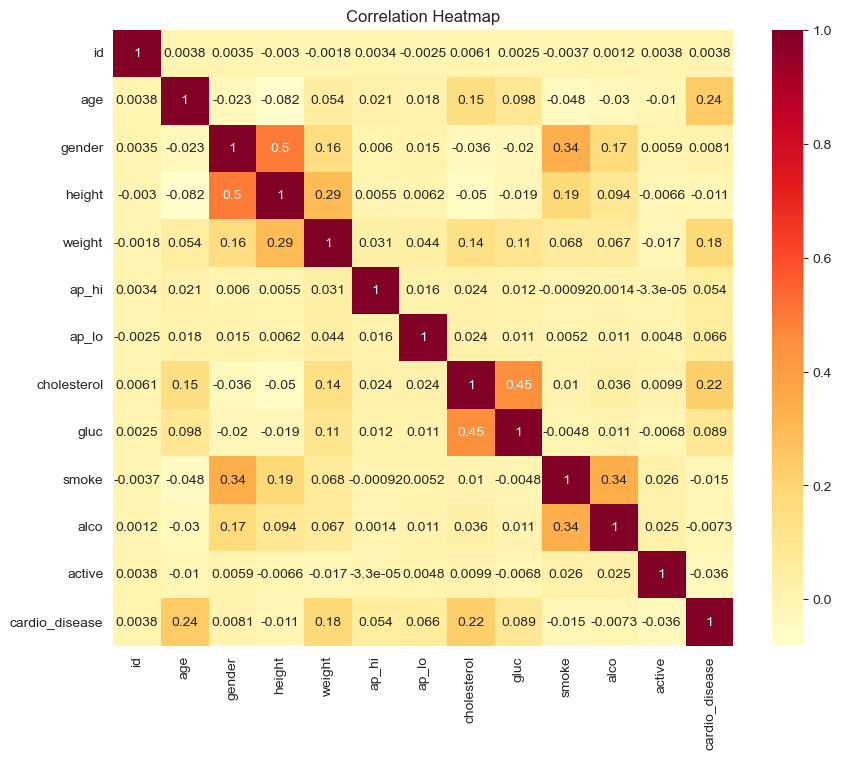

In [9]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(df.corr(), annot=True, ax=ax, cmap="YlOrRd")
plt.title("Correlation Heatmap")

From the above correlation heatmap, some pairs of variables with a positive correlation can be observed, such as:
- (age, cardio_disease)
- (gender, height)
- (gender, smoke)
- (height, weight)
- (weight, cardio_disease)
- (weight, ap_hi)
- (weight, ap_lo)
- (ap_hi, ap_lo)
- (ap_hi, cardio_disease)
- (ap_lo, cardio_disease)
- (cholesterol, gluc)
- (cholesterol, cardio_disease)
- (smoke, alco)

Therefore, there is a certain correlation between the variables, specifically in the case of cardiovascular diseases, a positive correlation is observed with increasing age, weight, ap_hight, ap_low, cholesterol, and partly with glucose.

### Structure Learning

piccola spiegazione

#### Utils

In [95]:
def get_f1_score(model, test_data, threshold=0.5):
    est_adj = nx.to_numpy_matrix(
        model.to_undirected(), nodelist=model.nodes(), weight=None
    )
    true_adj = np.corrcoef(test_data, rowvar=False)
    # print("Stimata")
    # print(est_adj)
    # print("Vera")
    # print(true_adj)
    # threshold imposta la soglia di cutoff a 0.5 (può essere modificata a seconda delle esigenze)
    true_adj = (true_adj > threshold).astype(int)  # Applica la soglia di cutoff alla matrice "vera"
    est_adj = (est_adj > threshold).astype(int)  # Applica la soglia di cutoff alla matrice stimata
    # print("-----------------------------------")
    # print("Stimata")
    # print(est_adj)
    # print("Vera")
    # print(true_adj)
    return f1_score(np.ravel(true_adj), np.ravel(est_adj))

#### PC

spiegazione

In [54]:
def PC_Structure_learning(train_data, max_cond_vars=4):
    est = PC(data=train_data)
    estimated_model = est.estimate(variant="stable", max_cond_vars=max_cond_vars)
    return estimated_model

#### Hill-Climb Search
spiegazione

In [8]:
def hill_climb_structure_learning(train_data, score_method): # score_method ["k2score", "bicscore"]
    hc = HillClimbSearch(train_data)
    estimated_model= hc.estimate(scoring_method=score_method)
    return estimated_model

#### Tree Search

In [9]:
def tree_search_structure_learning(train_data, estimator_type): # score_method ["chow-liu", "tan"]
    est = TreeSearch(train_data, root_node='cardio_disease')
    best_model = est.estimate(estimator_type=estimator_type)
    return best_model

#### Exhaustive Search
Utilizza un approccio di ricerca globale, ottimale fino a 5 variabili, proibitivo oltre. Nel caso di studio 0 si è voluto fare un esperimento anche con 6 variabili.

In [10]:
def exhaustive_search_structure_learning(train_data): 
    est = ExhaustiveSearch(train_data)
    best_model = est.estimate()
    return best_model

### Parameter Learning

In [11]:
def parameters_estimation(est_model, train_data):
    model = BayesianNetwork(est_model.edges())
    model.fit(data=train_data, estimator=MaximumLikelihoodEstimator)
    return model

### Evaluation

### Study Case 0 - Baseline

#### Remove Outliers
The boxplots show the presence of several outliers. Considering the dataset of 70K samples, it is reasonable to assume that there are some exceptional cases related to physical conditions. Below, we use the Interquartile range (IQR) method to analyze and remove the outliers.

In [12]:
def outliers(df, feature, factor=1.5):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    ls = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return ls

def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

def remove_outliers(dataset, features=["age", "height", "weight", "ap_hi", "ap_lo"], factor=1.5):
    index_list = []
    for feature in features:
        index_list.extend(outliers(dataset, feature, factor))

    dataset = remove(dataset, index_list)
    print("Number of outliers removed:", len(index_list))
    print("Number of rows left:", len(dataset))
    return dataset

In [13]:
dataset = df.copy()
dataset = remove_outliers(dataset)

Number of outliers removed: 8409
Number of rows left: 62502


In [14]:
dataset.describe().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
count,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.0,62502.00
mean,49941.88,52.91,1.35,164.41,73.18,126.42,81.70,1.36,1.22,0.09,0.05,0.8,0.49
std,28864.47,6.74,0.48,7.53,12.27,14.29,7.67,0.68,0.57,0.28,0.22,0.4,0.50
min,0.00,39.00,1.00,143.00,40.00,90.00,65.00,1.00,1.00,0.00,0.00,0.0,0.00
25%,24876.50,48.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
50%,49980.50,54.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
75%,74848.75,58.00,2.00,170.00,81.00,140.00,90.00,1.00,1.00,0.00,0.00,1.0,1.00
max,99999.00,64.00,2.00,186.00,107.00,170.00,105.00,3.00,3.00,1.00,1.00,1.0,1.00


#### Split dataset into trainset and testset

In [15]:
dataset_split(dataset, test_size=0.1)
train_data = pd.read_csv('cardio_train_set.csv', sep=';')
test_data = pd.read_csv('cardio_test_set.csv', sep=';')

#### Check trainset distribution

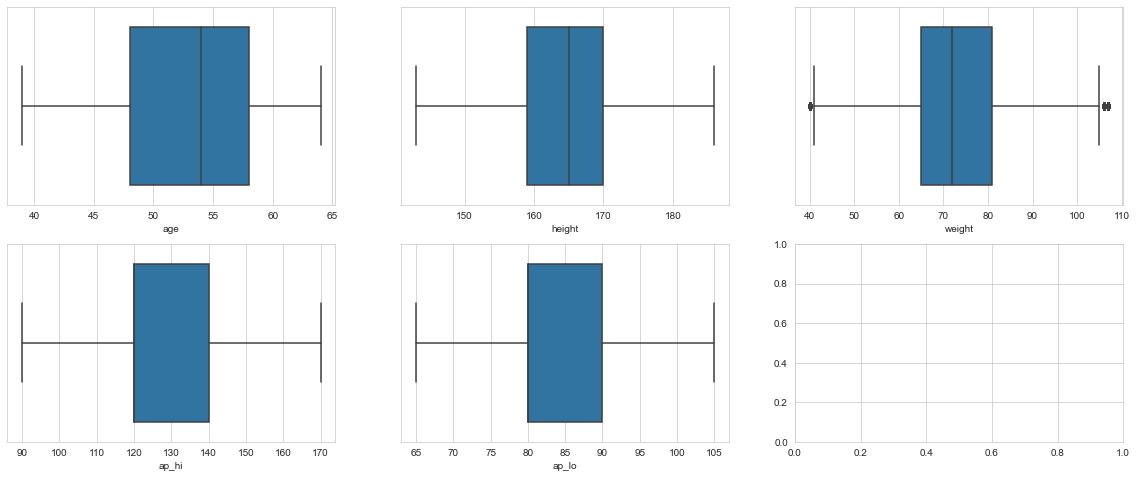

In [16]:
print_numeric_distribution(train_data)

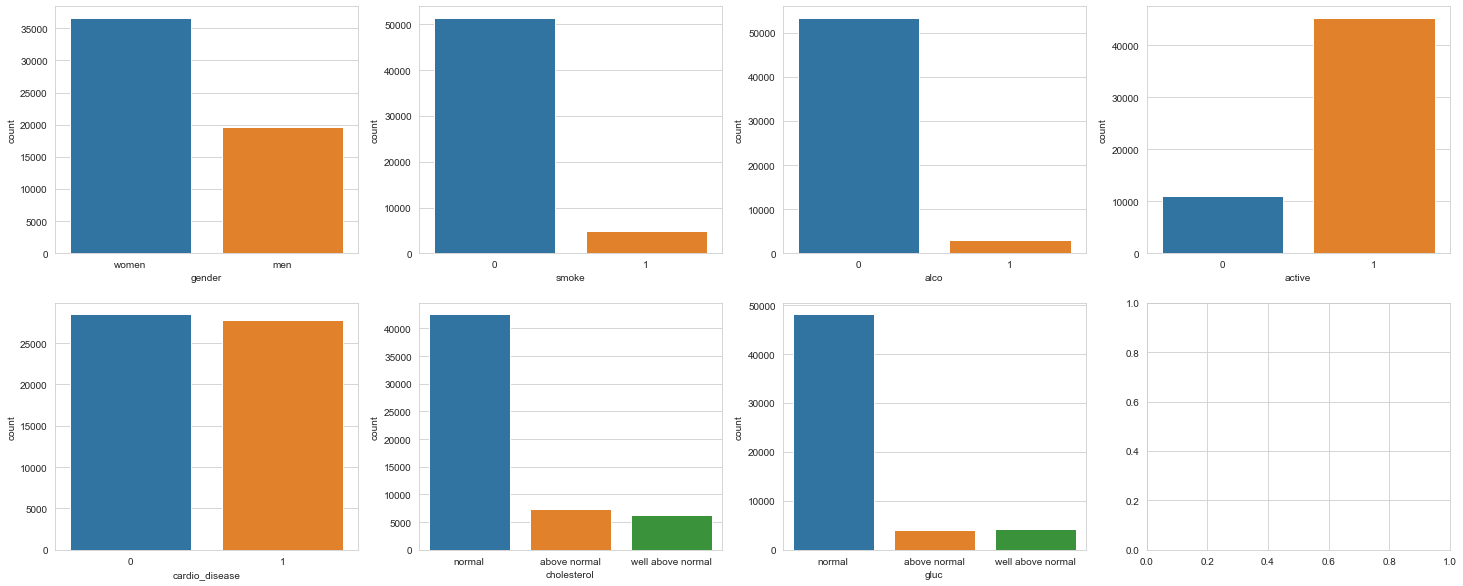

In [17]:
print_bin_cat_distribution(train_data)

#### Structure Learning

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pgmpy\base\DAG.py:1195: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(


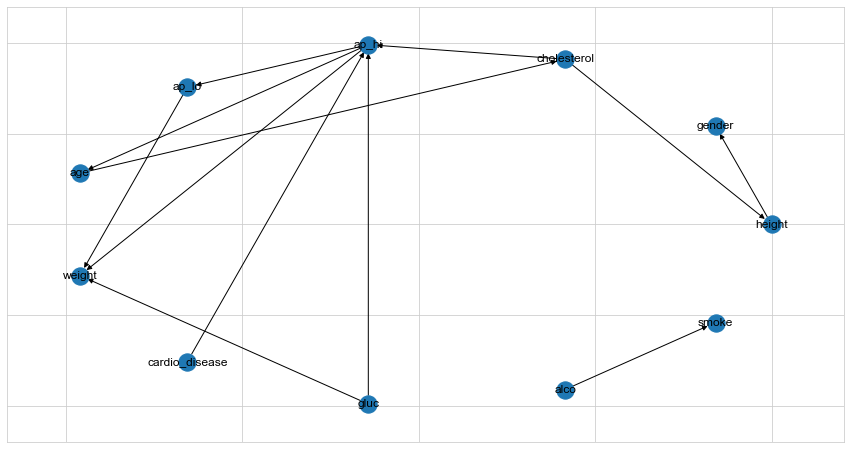

In [38]:
# PC
best_model = PC_Structure_learning(train_data)
draw_graphs([best_model])

In [96]:
#Si nota che l'attributo active non è presente nel grafo sopra
new_test = test_data.drop(["active"], axis=1)

get_f1_score(best_model, new_test, threshold=0.1)

0.24096385542168672

  0%|          | 0/1000000 [00:00<?, ?it/s]

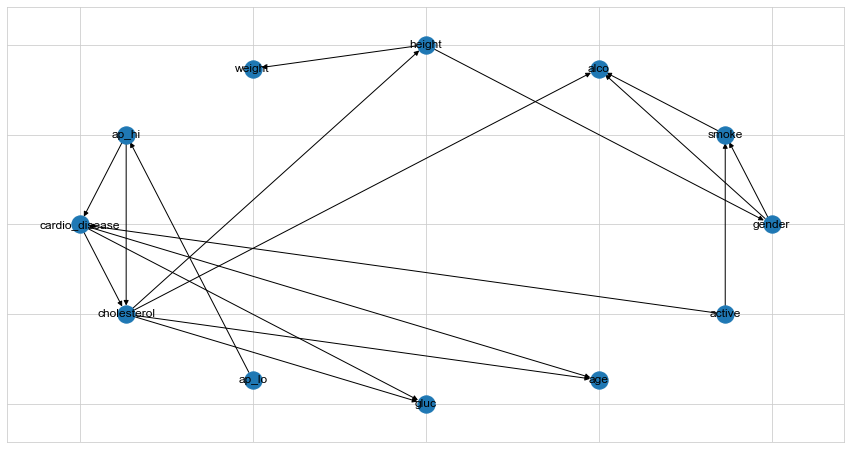

In [99]:
# HillClimbSearch
# score_method ["k2score", "bdeuscore", "bdsscore", "bicscore"]
best_model = hill_climb_structure_learning(train_data, score_method="k2score")
draw_graphs([best_model])

In [100]:
get_f1_score(best_model, test_data, threshold=0.1)

0.5106382978723405

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

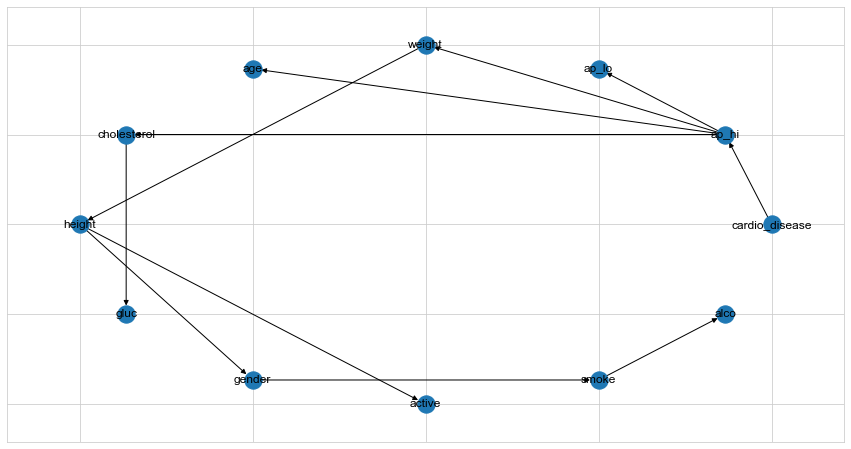

In [101]:
# Tree Search
best_model = tree_search_structure_learning(train_data, estimator_type="chow-liu") 
draw_graphs([best_model])

In [103]:
get_f1_score(best_model, test_data, threshold=0.1)

0.14634146341463417

In [ ]:
# Exhaustive Search
import time
new_train = train_data.drop(["height", "gluc", "gender", "active", "smoke", "alco"], axis=1)
start_time = time.time()
best_model = exhaustive_search_structure_learning(new_train) 
end_time = time.time()
print("Execution Time:", end_time - start_time, "seconds")
draw_graphs([best_model])

| N. Var |                               Var                                   | Execution Time         |
|:------:|:-------------------------------------------------------------------:|:----------------------:|
|    3   | "cardio_disease", "ap_hi", "ap_lo"                                  |      0.045 sec         |
|    4   | "cardio_disease", "ap_hi", "ap_lo", "weight"                        |      0.222 sec         |
|    5   | "cardio_disease", "ap_hi", "ap_lo", "weight", "age"                 |      17.583 sec        |
|    6   | "cardio_disease", "ap_hi", "ap_lo", "weight", "age", "cholesterol"  |      331 min ~ 5,51 h  |

![Exhaustive DAG 6 var](docs/Exhaustive_6_var.png)

In [39]:
model = parameters_estimation(best_model, train_data)
try:
    print(accuracy(model))
except Exception as e:
    print("Error:", e)
# 0.7174852023676211

  0%|          | 0/6177 [00:00<?, ?it/s]

0.7198848184290514


In [ ]:
# calcola la curva ROC e l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

# plotta la curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
q = inference(model, evidence= {'age': 60, 'gender': 2, 'height': 170, 'weight': 70, 'ap_hi': 120, 'ap_lo': 80, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1})
print(q)

+-------------------+-----------------------+
| cardio_disease    |   phi(cardio_disease) |
+===================+=======================+
| cardio_disease(0) |                0.6443 |
+-------------------+-----------------------+
| cardio_disease(1) |                0.3557 |
+-------------------+-----------------------+


### Study Case 1 - Reasonable Outliers and Interval Discretization

Number of outliers removed: 2327
Number of rows left: 67831


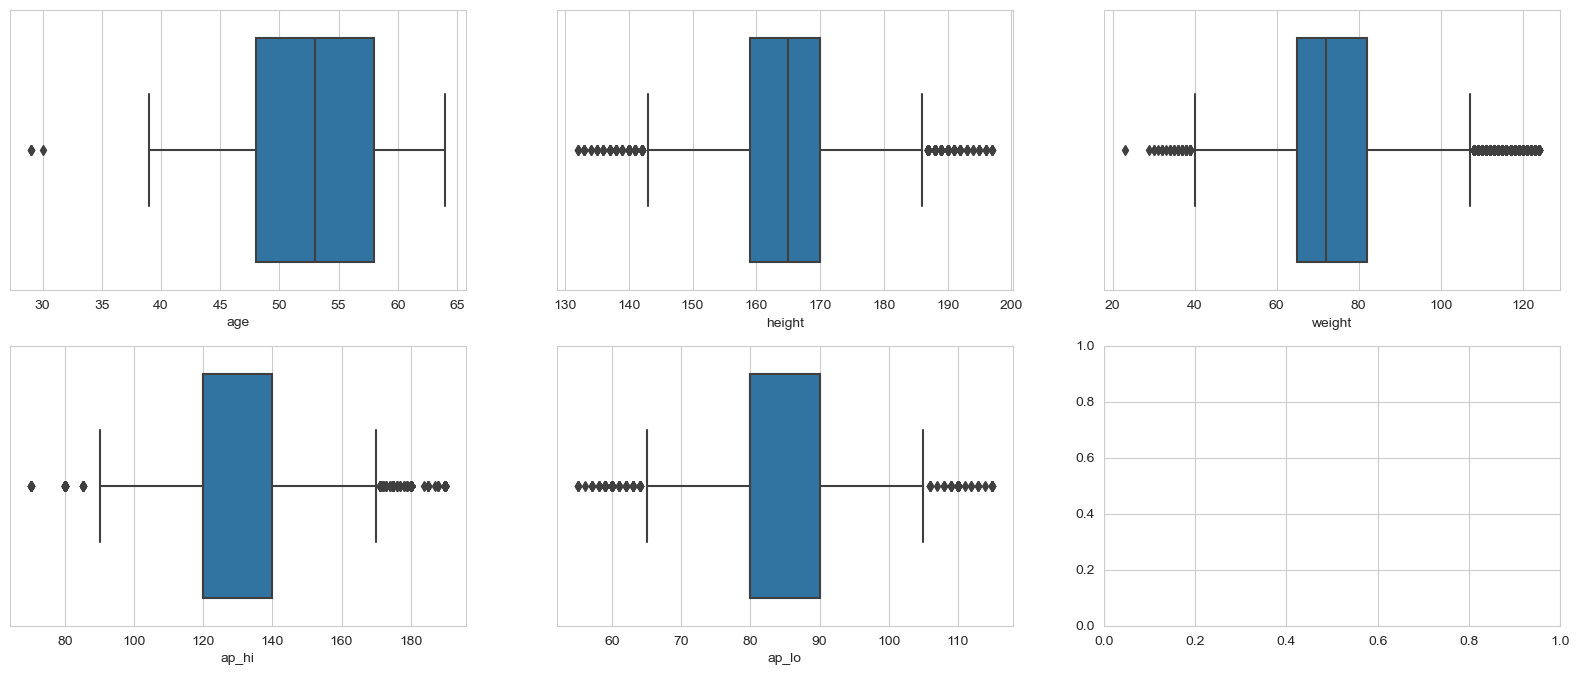

In [112]:
# Removing far outliers
dataset = df.copy()
dataset = remove_outliers(dataset, factor=2.5)
print_numeric_distribution(dataset)

##### Interval Discretization

In [113]:
dataset['age_discretized'], dataset['age']  = interval_discr(dataset['age'], bins=15)
dataset['height_discretized'], dataset['height']  = interval_discr(dataset['height'], bins=20)
dataset['weight_discretized'], dataset['weight']  = interval_discr(dataset['weight'], bins=20)
dataset['ap_hi_discretized'], dataset['ap_hi']  = interval_discr(dataset['ap_hi'], bins=15)
dataset['ap_lo_discretized'], dataset['ap_lo']  = interval_discr(dataset['ap_lo'], bins=15)

dataset.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease,age_discretized,height_discretized,weight_discretized,ap_hi_discretized,ap_lo_discretized
0,0,8,2,11,7,4,6,1,1,0,0,1,0,"(47.667, 50.0]","(167.75, 171.0]","(58.35, 63.4]","(102.0, 110.0]","(79.0, 83.0]"
1,1,11,1,7,12,8,8,3,1,0,0,1,1,"(54.667, 57.0]","(154.75, 158.0]","(83.6, 88.65]","(134.0, 142.0]","(87.0, 91.0]"
2,2,9,1,10,8,7,3,3,1,0,0,0,1,"(50.0, 52.333]","(164.5, 167.75]","(63.4, 68.45]","(126.0, 134.0]","(67.0, 71.0]"
3,3,8,2,11,11,9,11,1,1,0,0,1,1,"(47.667, 50.0]","(167.75, 171.0]","(78.55, 83.6]","(142.0, 150.0]","(99.0, 103.0]"
4,4,7,1,7,6,3,1,1,1,0,0,0,0,"(45.333, 47.667]","(154.75, 158.0]","(53.3, 58.35]","(94.0, 102.0]","(59.0, 63.0]"


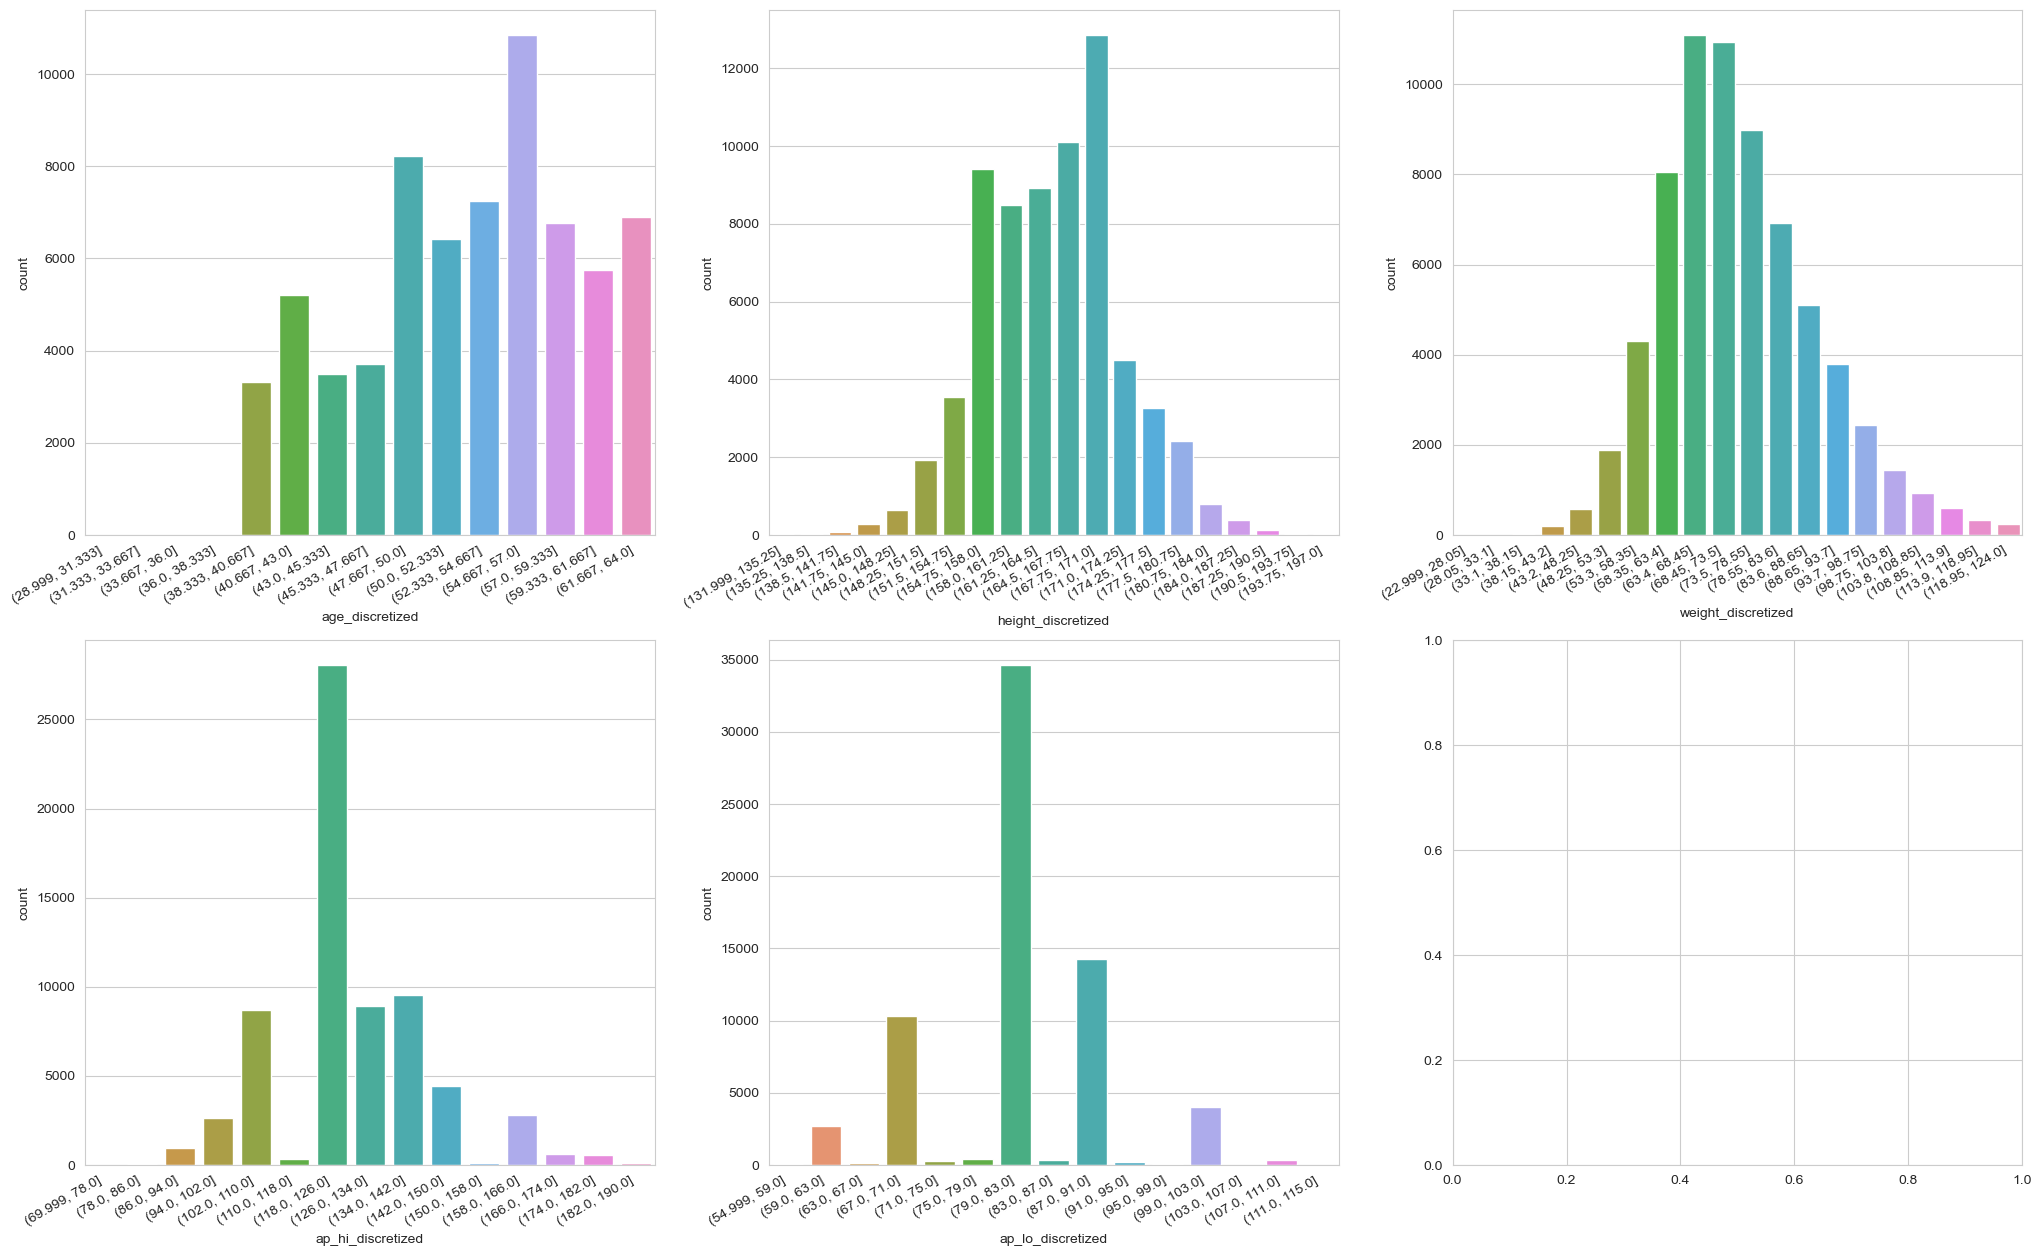

In [117]:
cat_cols = ["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    g = sns.countplot(x=col, data=dataset, ax=axes[i])
    axes[i].set_xlabel(col)
    g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")


#### Split dataset into trainset and testset

In [118]:
dataset.drop(["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"], axis=1, inplace=True)
dataset_split(dataset, test_size=0.1)
train_data = pd.read_csv('cardio_train_set.csv', sep=';')
test_data = pd.read_csv('cardio_test_set.csv', sep=';')

#### Distribution

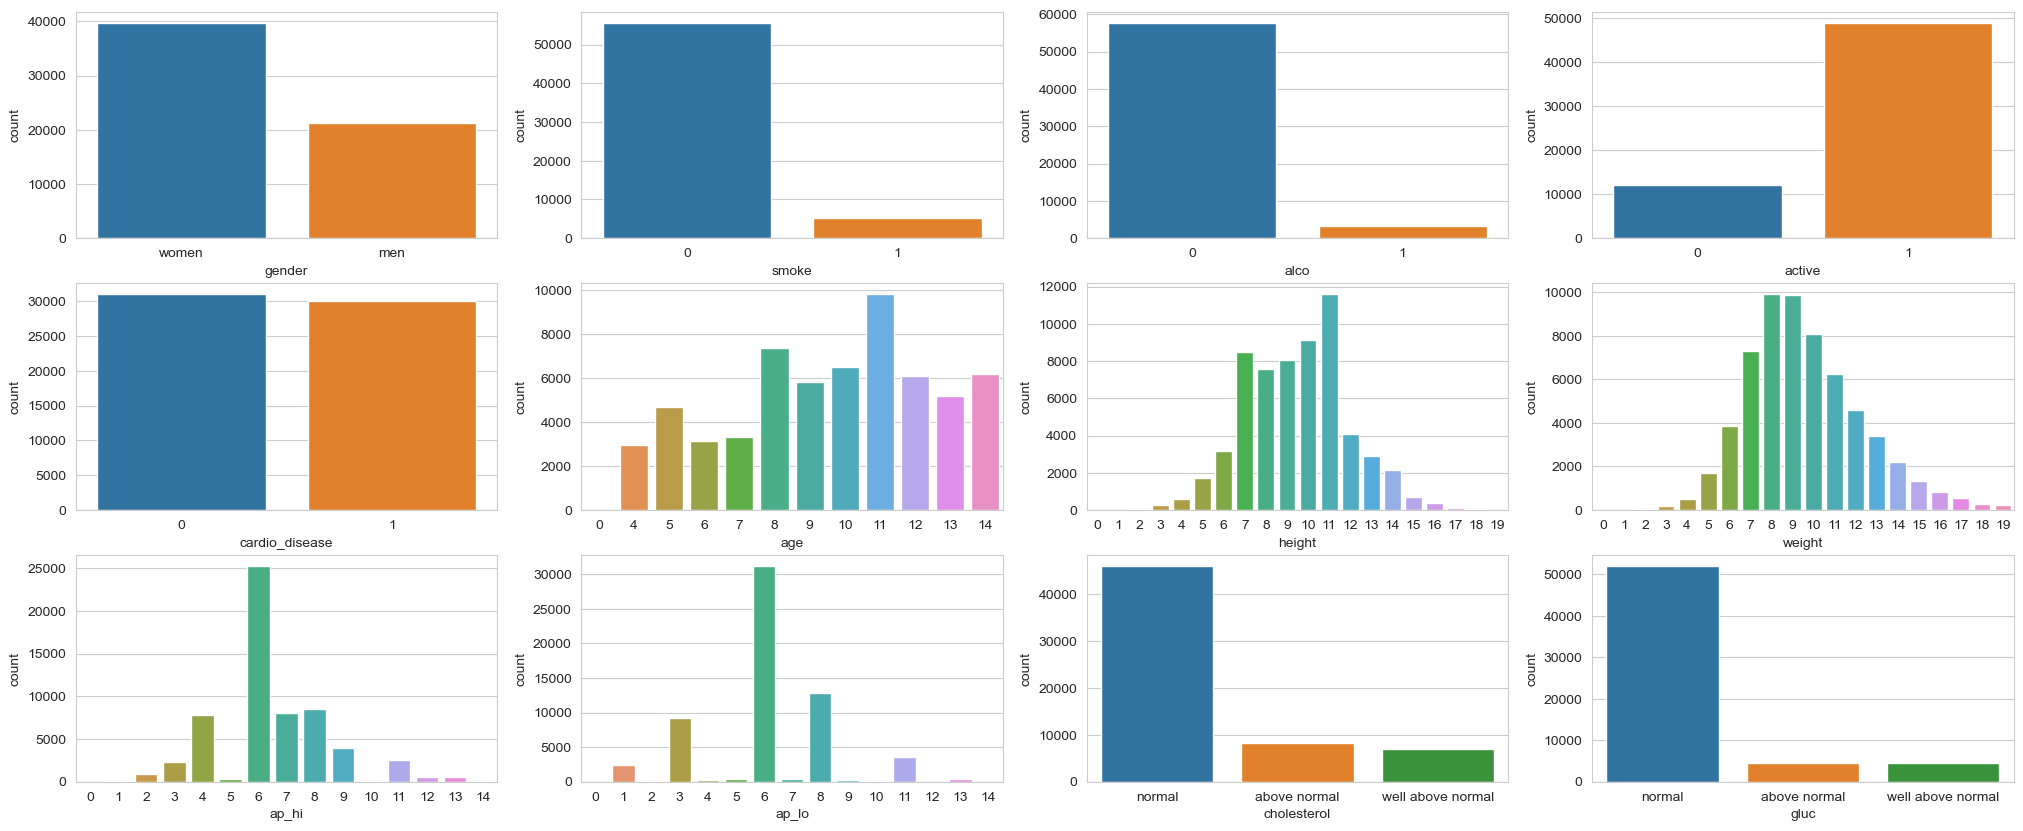

In [119]:
print_bin_cat_distribution(train_data, cat_cols=["age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"], nrows=3, ncols=4)

#### HillClimbSearch

  0%|          | 0/1000000 [00:00<?, ?it/s]

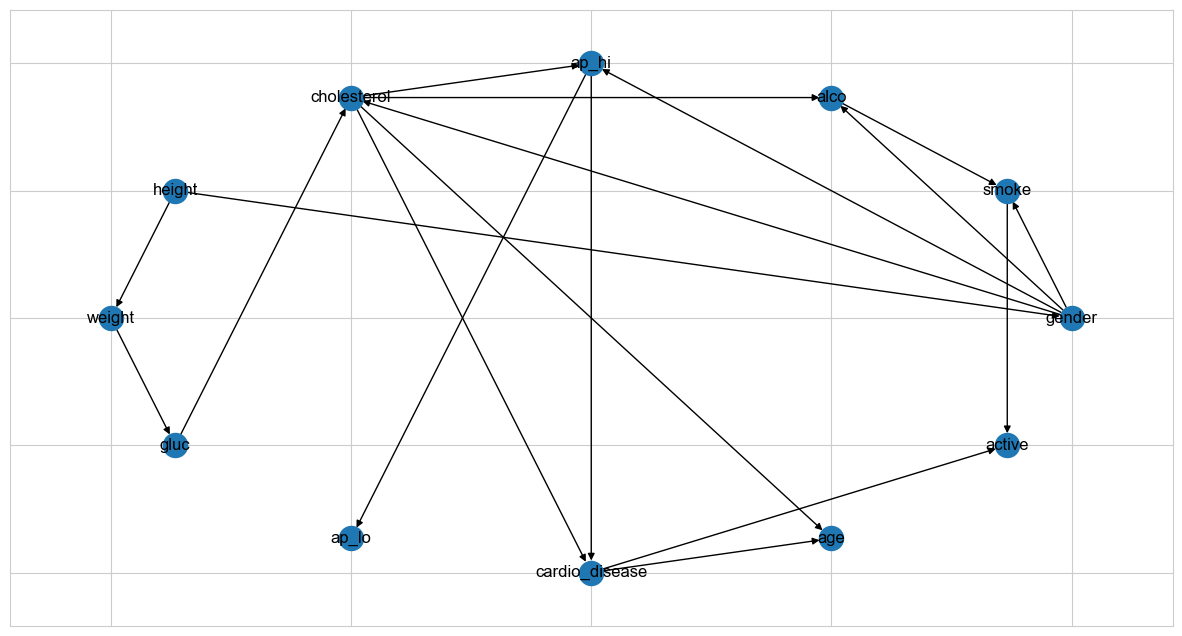

In [143]:
best_model = hill_climb_structure_learning(train_data, score_method="bicscore")
draw_graphs([best_model])

In [ ]:
import time

new_train = train_data.drop(["weight", "age", "cholesterol", "height", "gluc", "gender", "active", "smoke", "alco"], axis=1)

start_time = time.time()

best_model = exhaustive_search_structure_learning(new_train) 

end_time = time.time()

elapsed_time = end_time - start_time
print("Tempo di esecuzione:", elapsed_time, "secondi")
draw_graphs([best_model])

# 3 variabili ["cardio_disease", "ap_hi", "ap_lo"]
# Tempo di esecuzione: 0.04503798484802246 secondi

# 4 variabili ["cardio_disease", "ap_hi", "ap_lo", "weight"]
# Tempo di esecuzione: 0.22294187545776367 secondi

# 5 variabili ["cardio_disease", "ap_hi", "ap_lo", "weight", "age"]
# Tempo di esecuzione: 17.583510160446167 secondi

# 6 variabili ["cardio_disease", "ap_hi", "ap_lo", "weight", "age", "cholesterol"]
# Tempo di esecuzione: 17.583510160446167 secondi

In [138]:
model = parameters_estimation(best_model, train_data)
try:
    print(accuracy(model))
except Exception as e:
    print("Error:", e)

  0%|          | 0/5895 [00:00<?, ?it/s]

0.7339327830188679


In [142]:
q = inference(model, evidence= {'age': 9, 'gender': 2, 'height': 11, 'weight': 9, 'ap_hi': 6, 'ap_lo': 6, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1})
print(q)

+-------------------+-----------------------+
| cardio_disease    |   phi(cardio_disease) |
+===================+=======================+
| cardio_disease(0) |                0.7066 |
+-------------------+-----------------------+
| cardio_disease(1) |                0.2934 |
+-------------------+-----------------------+


### Study Case 2 - Reasonable Outliers and Quantile Discretization

Number of outliers removed: 2327
Number of rows left: 67831


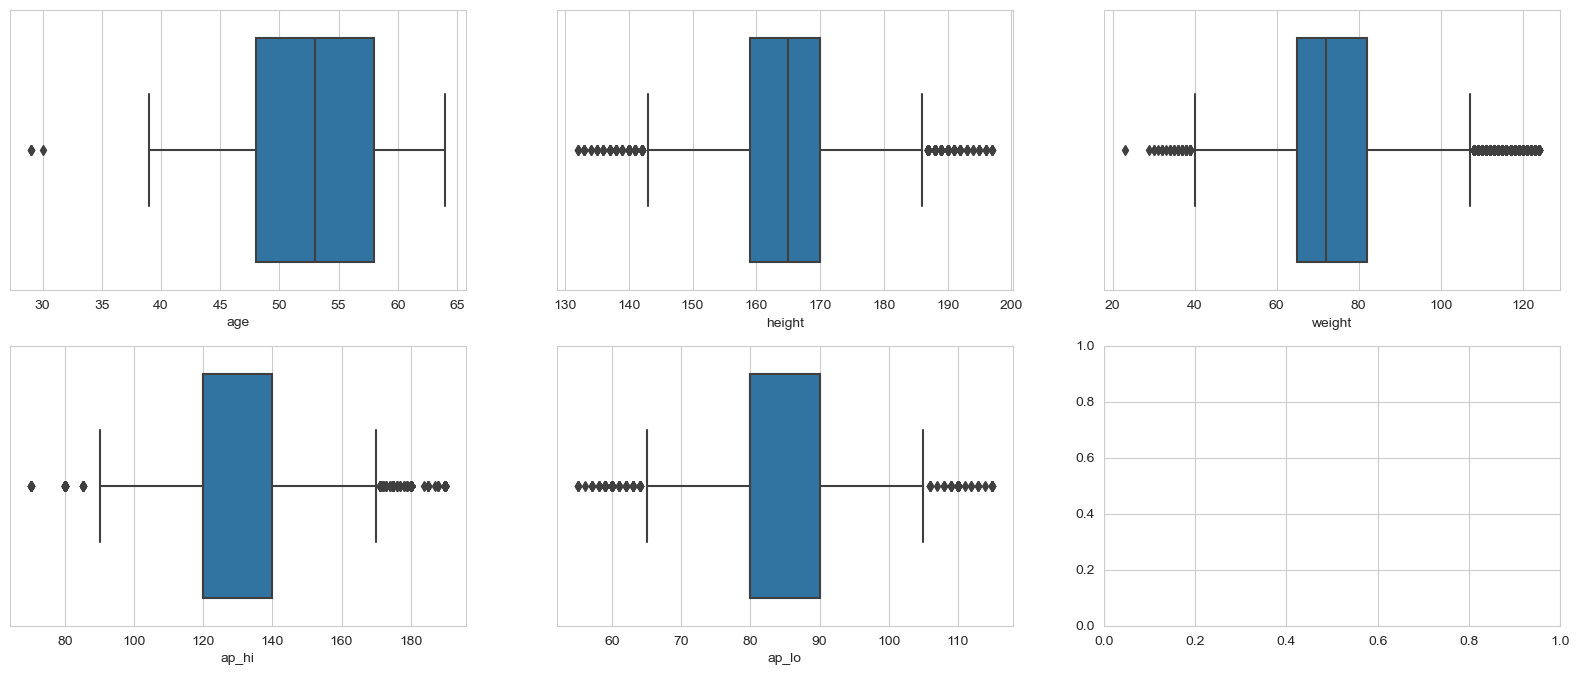

In [150]:
# Removing far outliers
dataset = df.copy()
dataset = remove_outliers(dataset, factor=2.5)
print_numeric_distribution(dataset)

##### Quantile Discretization

In [151]:
dataset['age_discretized'] = pd.qcut(dataset['age'], q=10)
dataset['height_discretized'] = pd.qcut(dataset['height'], q=10)
dataset['weight_discretized'] = pd.qcut(dataset['weight'], q=10)
dataset['ap_hi_discretized'] = pd.qcut(dataset['ap_hi'],  q=3)
dataset['ap_lo_discretized'] = pd.qcut(dataset['ap_lo'],  q=2)

dataset.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease,age_discretized,height_discretized,weight_discretized,ap_hi_discretized,ap_lo_discretized
0,0,50,2,168,62,110,80,1,1,0,0,1,0,"(49.0, 51.0]","(166.0, 168.0]","(58.0, 63.0]","(69.999, 120.0]","(54.999, 80.0]"
1,1,55,1,156,85,140,90,3,1,0,0,1,1,"(53.0, 55.0]","(155.0, 158.0]","(80.0, 85.0]","(130.0, 190.0]","(80.0, 115.0]"
2,2,51,1,165,64,130,70,3,1,0,0,0,1,"(49.0, 51.0]","(162.0, 165.0]","(63.0, 65.0]","(120.0, 130.0]","(54.999, 80.0]"
3,3,48,2,169,82,150,100,1,1,0,0,1,1,"(46.0, 49.0]","(168.0, 170.0]","(80.0, 85.0]","(130.0, 190.0]","(80.0, 115.0]"
4,4,47,1,156,56,100,60,1,1,0,0,0,0,"(46.0, 49.0]","(155.0, 158.0]","(22.999, 58.0]","(69.999, 120.0]","(54.999, 80.0]"


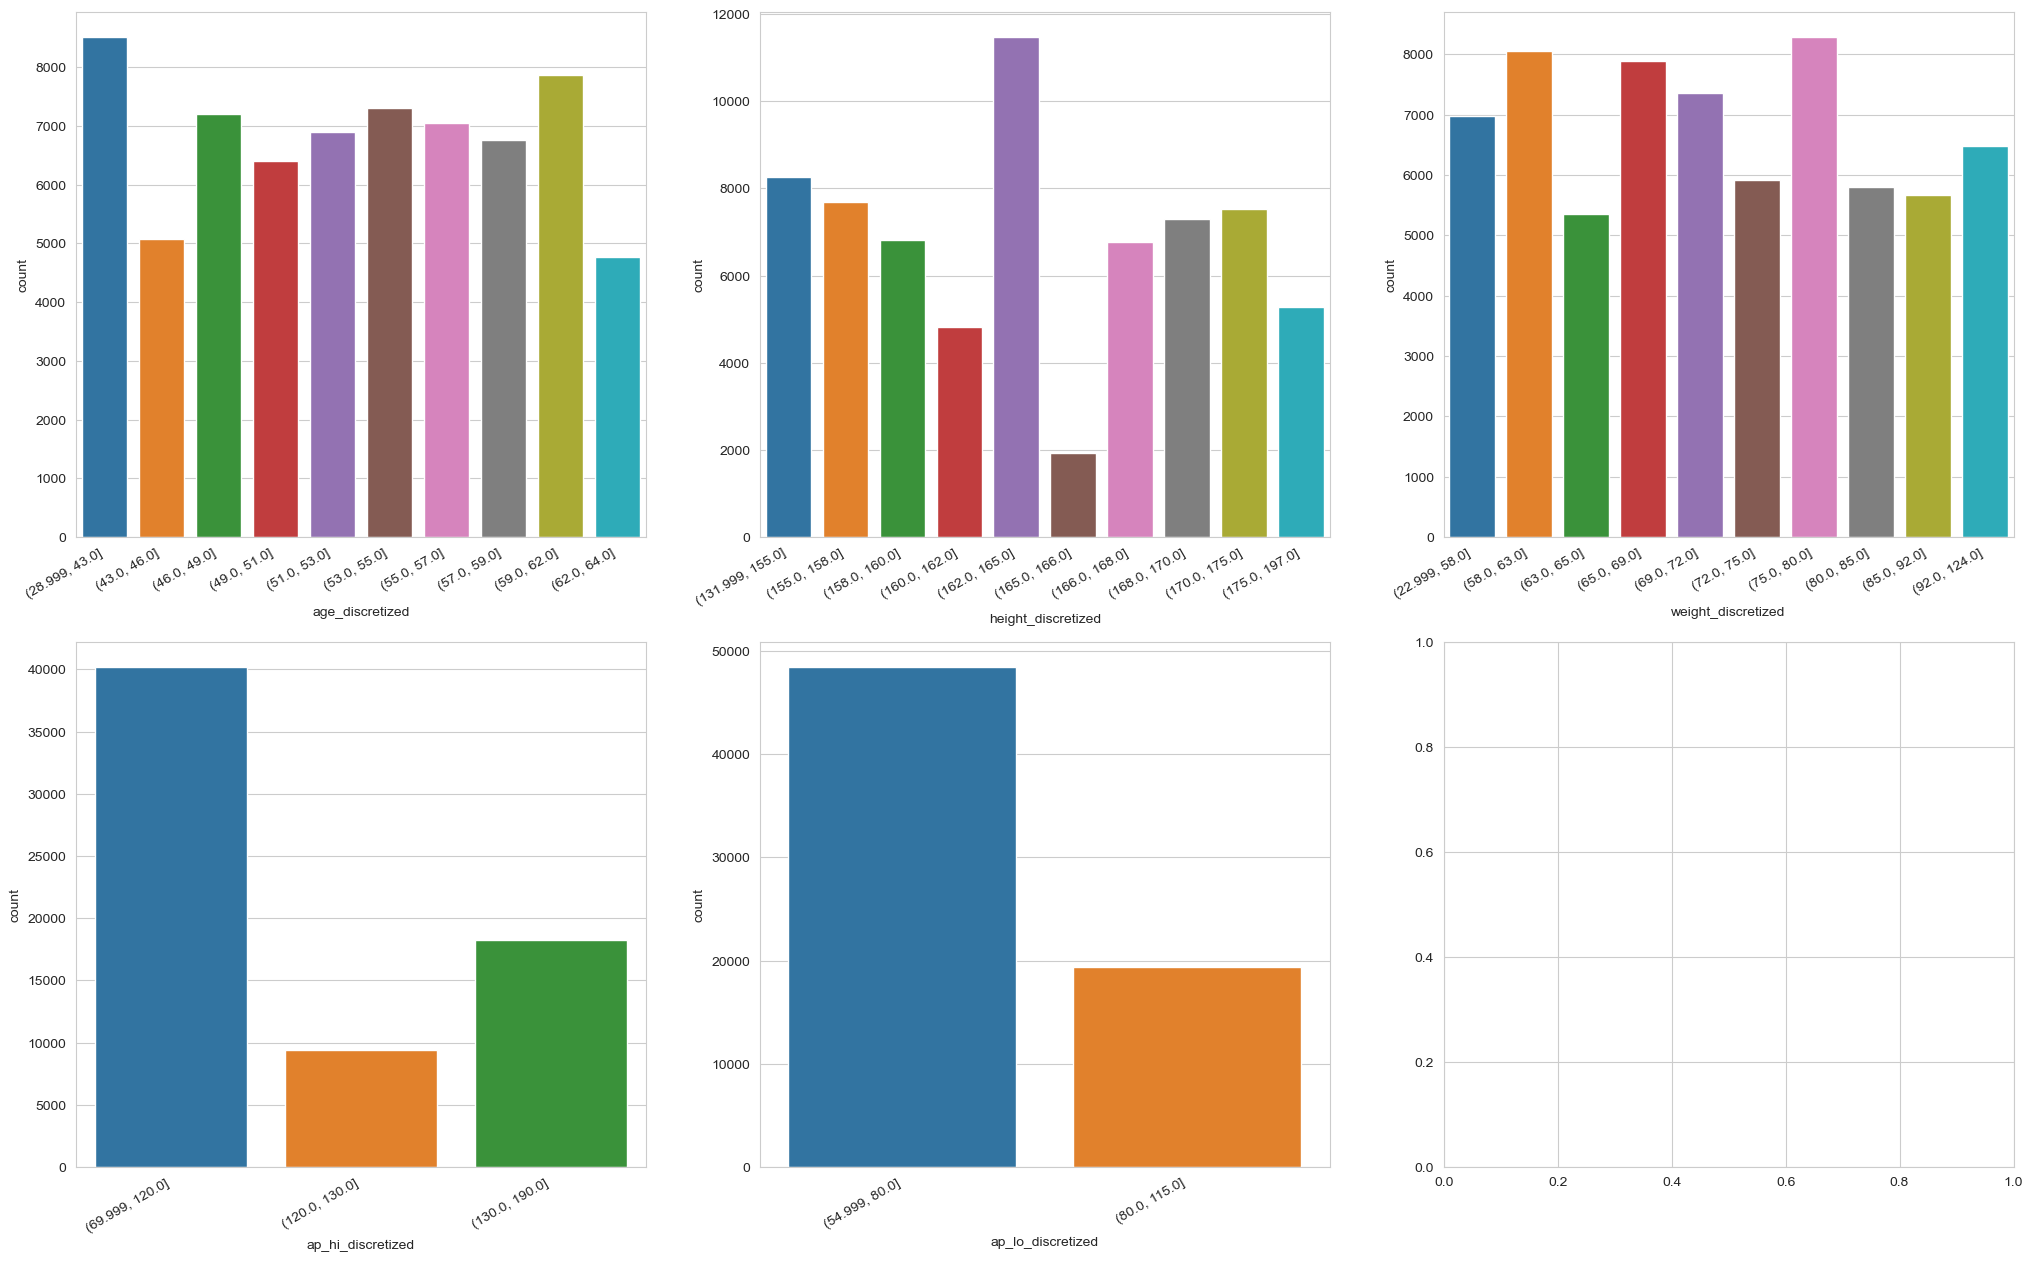

In [152]:
cat_cols = ["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    g = sns.countplot(x=col, data=dataset, ax=axes[i])
    axes[i].set_xlabel(col)
    g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")

In [153]:
dataset['age'] = pd.factorize(dataset['age_discretized'])[0]
dataset['height'] = pd.factorize(dataset['height_discretized'])[0]
dataset['weight'] = pd.factorize(dataset['weight_discretized'])[0]
dataset['ap_hi'] = pd.factorize(dataset['ap_hi_discretized'])[0]
dataset['ap_lo'] = pd.factorize(dataset['ap_lo_discretized'])[0]

dataset.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
0,0,0,2,0,0,0,0,1,1,0,0,1,0
1,1,1,1,1,1,1,1,3,1,0,0,1,1
2,2,0,1,2,2,2,0,3,1,0,0,0,1
3,3,2,2,3,1,1,1,1,1,0,0,1,1
4,4,2,1,1,3,0,0,1,1,0,0,0,0


#### Split dataset into trainset and testset

In [154]:
#dataset.drop(["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"], axis=1, inplace=True)
dataset_split(dataset, test_size=0.1)
train_data = pd.read_csv('cardio_train_set.csv', sep=';')
test_data = pd.read_csv('cardio_test_set.csv', sep=';')

#### Distribution

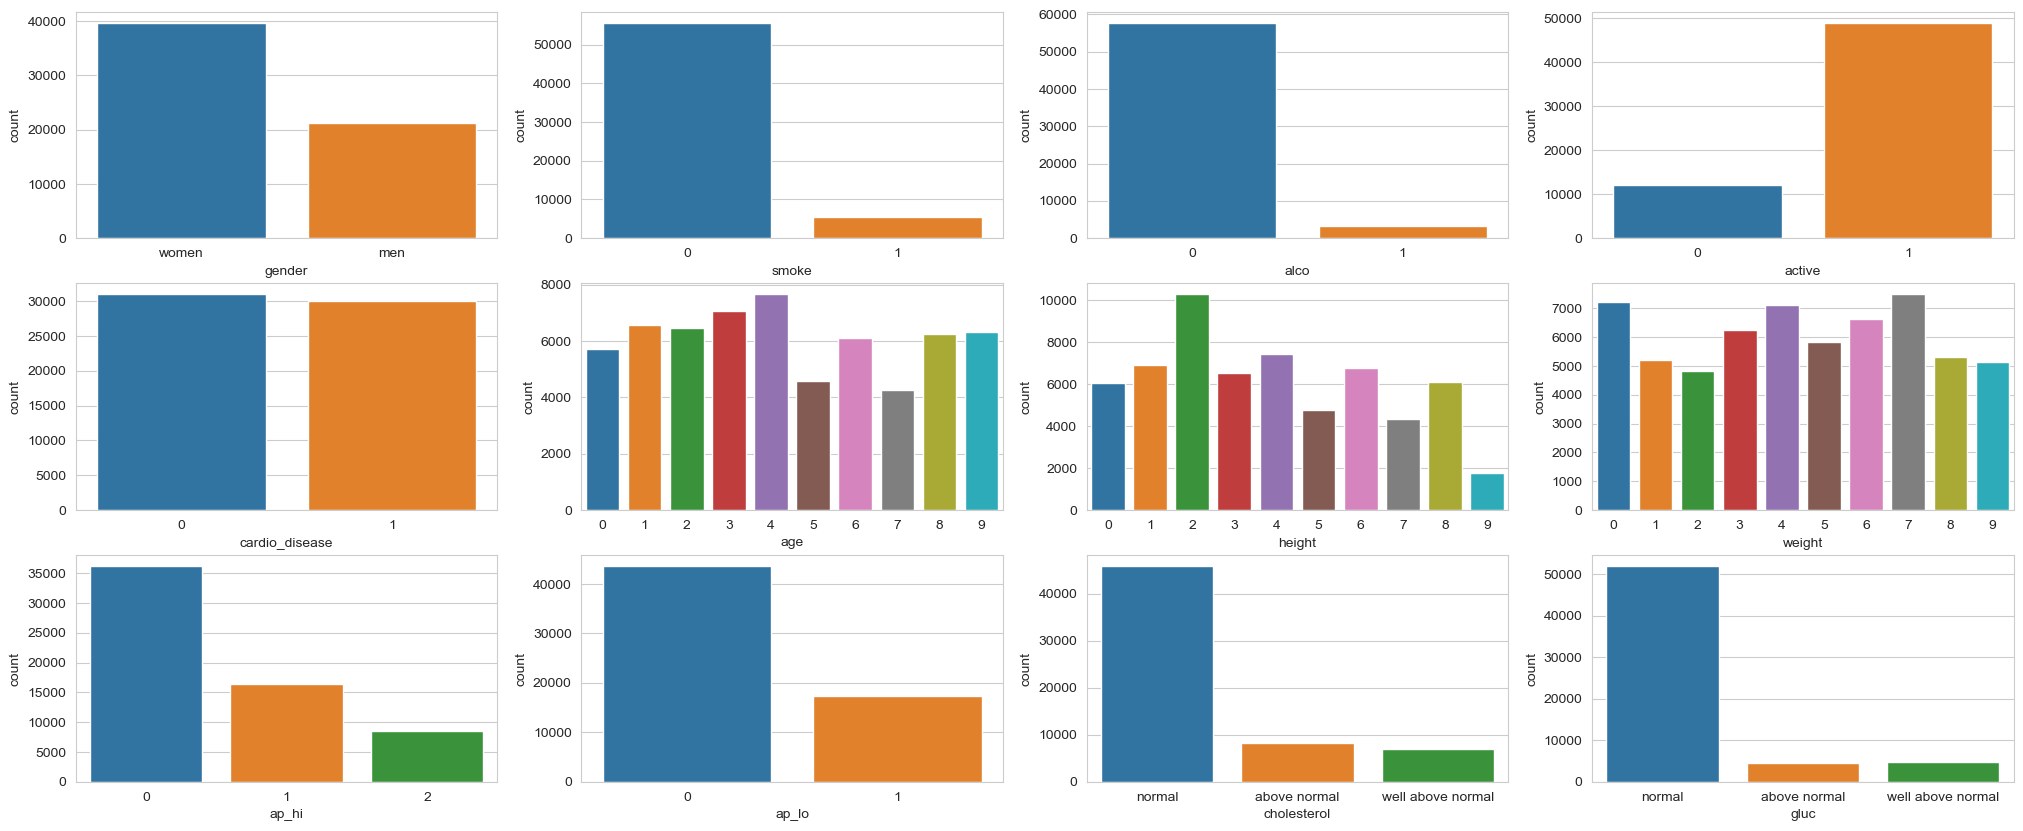

In [155]:
print_bin_cat_distribution(train_data, cat_cols=["age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"], nrows=3, ncols=4)

#### HillClimbSearch

  0%|          | 0/1000000 [00:00<?, ?it/s]

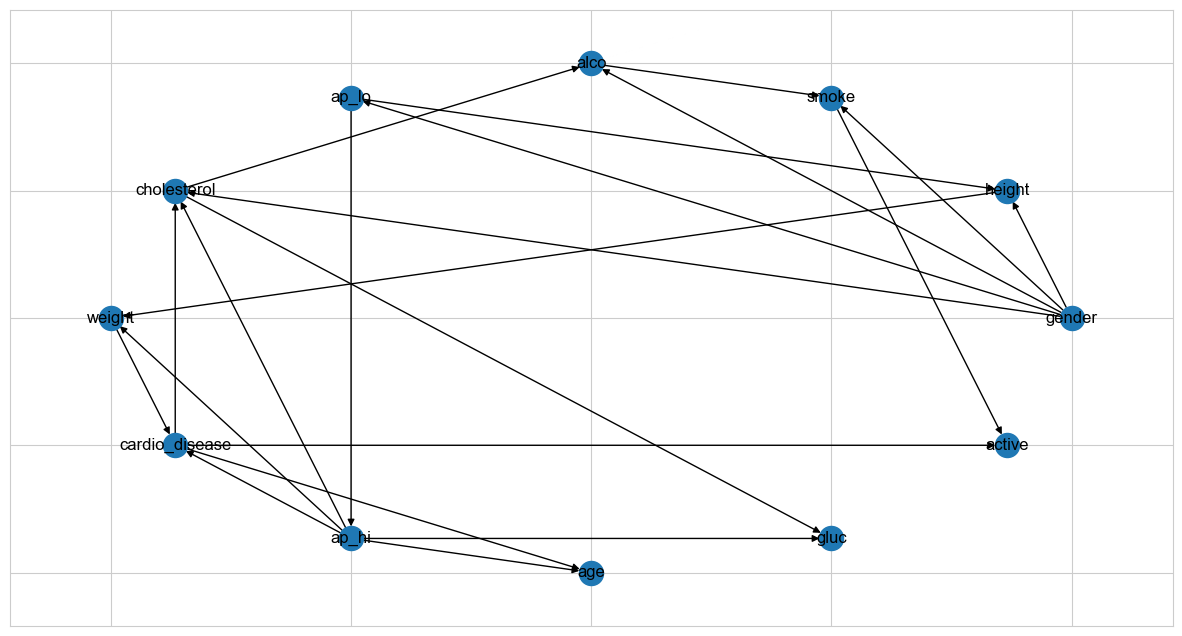

In [156]:
best_model = hill_climb_structure_learning(train_data, score_method="bicscore")
draw_graphs([best_model])

In [157]:
model = parameters_estimation(best_model, train_data)
try:
    print(accuracy(model))
except Exception as e:
    print("Error:", e)

  0%|          | 0/5129 [00:00<?, ?it/s]

0.7256780660377359


In [ ]:
q = inference(model, evidence= {'age': 60, 'gender': 2, 'height': 170, 'weight': 70, 'ap_hi': 120, 'ap_lo': 80, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1})
print(q)

### Output and Test